In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

## 01. Generate list of taxa seen in all ASV data

In [12]:
os.chdir("/Users/nastassia.patin/GitHub/MarineDNA/Data/filtered_data")

In [13]:
# 18S
tax_Fly2018 = pd.read_csv("Flyer2018_18S_taxa_filtered.csv")
tax_Lask2018 = pd.read_csv("RREAS2018_18S_taxa_filtered.csv")

In [16]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/RREAS Cruises/Lasker2019/18S Amplicons/filtered_seq_data")

In [17]:
tax_Lask2019 = pd.read_csv("RREAS2019_18S_taxa_filtered.csv")

In [18]:
tax_Fly2018 = tax_Fly2018.drop(columns={"Unnamed: 0", 
                                        "Species"}).drop_duplicates(subset=None,
                                                                    keep="first",
                                                                    inplace=False)
tax_Lask2018 = tax_Lask2018.drop(columns={"Unnamed: 0", 
                                          "Species"}).drop_duplicates(subset=None,
                                                                      keep="first",
                                                                      inplace=False)
tax_Lask2019 = tax_Lask2019.drop(columns={"Unnamed: 0", 
                                          "Species"}).drop_duplicates(subset=None,
                                                                      keep="first",
                                                                      inplace=False)

In [19]:
tax_merged = pd.merge(tax_Fly2018, tax_Lask2018, 
                          how="outer", 
                          on=("Genus", "Family", "Order", "Class", "Phylum", "Kingdom"))

In [20]:
tax_merged = pd.merge(tax_merged, tax_Lask2019,
                          how="outer", 
                          on=("Genus", "Family", "Order", "Class", "Phylum", "Kingdom"))
tax_merged.head(3)

In [10]:
tax_merged_COI = tax_merged

In [22]:
tax_merged_18S = tax_merged

#### Make a list of all taxa observed in both ASV data sets

In [25]:
tax_merged_COI.shape

(907, 6)

In [26]:
tax_merged_18S.shape

(1475, 6)

In [27]:
tax_merged_ASVs = tax_merged_COI.merge(tax_merged_18S, how='outer')
tax_merged_ASVs.shape

(2107, 6)

In [29]:
tax_merged_ASVs.head(3)

Kingdom      Phylum        Class              Order            Family  \
0  unassigned  unassigned   unassigned         unassigned        unassigned   
1   Eukaryota    Haptista   Haptophyta     Isochrysidales  Noelaerhabdaceae   
2   Eukaryota  Arthropoda  Hexanauplia  Poecilostomatoida         Oncaeidae   

        Genus  
0  unassigned  
1   Emiliania  
2          g_

## 2a. Link observed taxa to full taxonomy (ASVs only)

In [70]:
# COI or 18S
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs/taxa lists")
asvs = pd.read_csv("COI_genera_ASVs_ONLY.csv")
#asvs = pd.read_csv("18S_genera_ASVs_ONLY.csv")
asvs.head(3)

Genus
0   Acanthephyra
1  Sphaeronectes
2  Clausocalanus

In [71]:
asvs_fulltax = pd.merge(asvs, tax_merged, on='Genus', how='left')
phy_gen = asvs_fulltax.groupby('Phylum').count().reset_index()[['Phylum', 'Genus']]
asvs_fulltax.head(3)

Genus    Kingdom      Phylum         Class          Order  \
0   Acanthephyra  Eukaryota  Arthropoda  Malacostraca       Decapoda   
1  Sphaeronectes  Eukaryota    Cnidaria      Hydrozoa  Siphonophorae   
2  Clausocalanus  Eukaryota  Arthropoda   Hexanauplia      Calanoida   

            Family  
0     Oplophoridae  
1  Sphaeronectidae  
2  Clausocalanidae

In [72]:
#phy_gen['Data set'] = '18S'
phy_gen['Data set'] = 'COI'

In [73]:
#phy_gen_18S = phy_gen
phy_gen_COI = phy_gen

In [74]:
phy_gen = pd.concat([phy_gen_18S, phy_gen_COI])

In [75]:
pivot = pd.pivot_table(data=phy_gen, 
                       index=['Data set'], 
                       columns=['Phylum'], 
                       values='Genus').fillna(0)
pivot

Phylum    Annelida  Arthropoda  Ascomycota  Bacillariophyta  Basidiomycota  \
Data set                                                                     
18S           25.0        18.0        12.0             26.0            4.0   
COI           24.0        35.0         5.0              9.0            0.0   

Phylum    Brachiopoda  Bryozoa  Cercozoa  Chaetognatha  Chlorophyta  ...  \
Data set                                                             ...   
18S               1.0      1.0      20.0           2.0         21.0  ...   
COI               1.0      2.0       0.0           1.0          3.0  ...   

Phylum    Nemertea  Phoronida  Picozoa  Platyhelminthes  Porifera  Rhodophyta  \
Data set                                                                        
18S            4.0        0.0      1.0              3.0       0.0         0.0   
COI            6.0        1.0      0.0              0.0       5.0         6.0   

Phylum    Rotifera  Streptophyta  Tubulinea  unknown  
Data set                                              
18S            3.0          15.0        2.0    184.0  
COI            1.0           1.0        0.0     19.0  

[2 rows x 39 columns]

## 2b. Make the stacked bar plot

[Text(0, 0, '18S'), Text(1, 0, 'COI')]

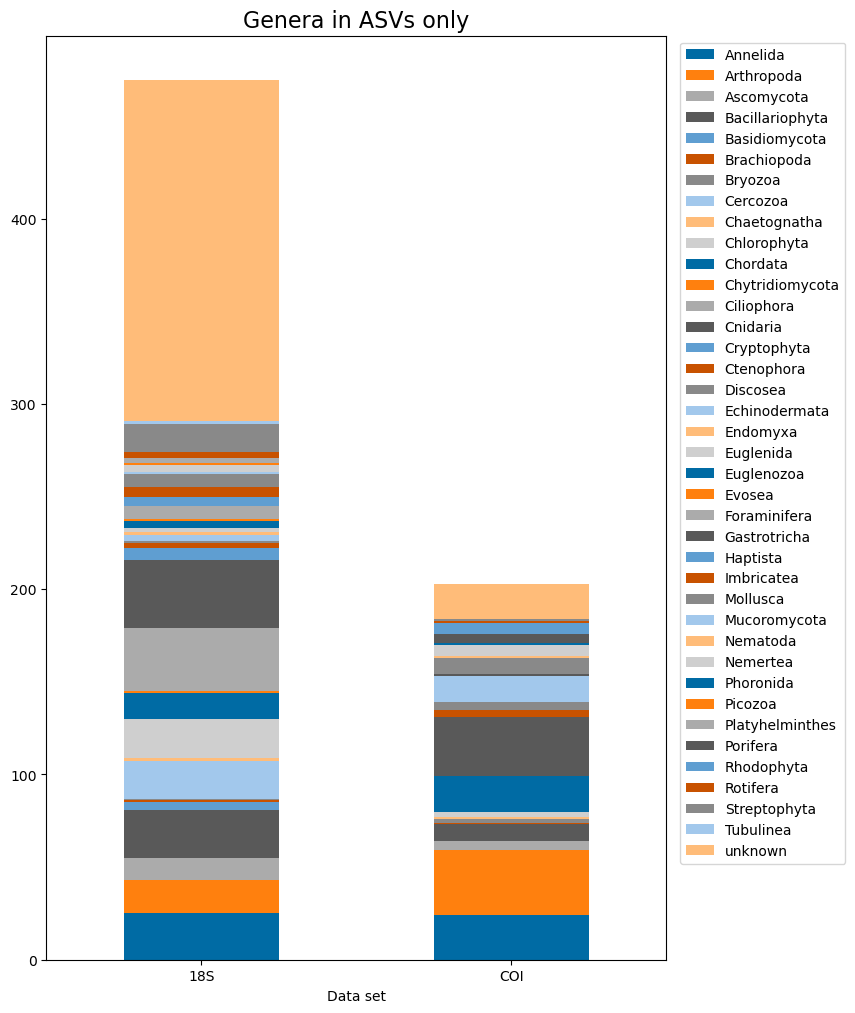

In [77]:
style.use('tableau-colorblind10')

ax = pivot.plot.bar(stacked=True, figsize=(8,12))

ax.legend(bbox_to_anchor=(1.3, 1),
          ncol=1, fancybox=True)
ax.set_title('Genera in ASVs only', fontsize=16)
ax.set_xticklabels(['18S','COI'], rotation=0)

In [78]:
ax.figure.savefig('ASVs_only.png', bbox_inches='tight')

## 3. Generate full taxonomy file of metagenome taxa

#### This section generates a list of all taxa observed in the metagenomes. It also standardizes the full taxonomic ranking for all genera so there are no conflicting higher level classifications.

In [30]:
def compile_mgn_genera(file):
    tax = pd.read_csv(file)
    names = ['query name','rank','fraction','lineage','query_md5','query_filename',
         'f_weighted_at_rank','bp_match_at_rank']
    tax.columns = names
    gen = pd.DataFrame(tax.loc[tax['rank'] == 'genus']['lineage'])
    # n should be changed to however many ranks are in the desired taxonomic level
    gen[['Domain',
         'Phylum',
         'Class',
         'Order',
         'Family',
         'Genus']] = gen['lineage'].str.split(';', n=6, expand=True)   
    return(gen)

In [31]:
os.chdir("/Users/nastassia.patin/GitHub/eDNA-Visualizations/Euks_mgns_asvs_data/sourmash_summaries/")

In [32]:
df_genera_mgns = []

for file in glob.glob('*summarized.csv'):
    gen = compile_mgn_genera(file)
    gen = gen.drop(columns={'lineage'})
    df_genera_mgns.append(gen)
    
df = pd.concat(df_genera_mgns)
df = df.replace('[a-z]__', '', regex=True)

### There are unfortunately some differences in taxonomy spellings that should be identical; need to get rid of those

In [33]:
df = df.replace('Pelagomonodaceae', 'Pelagomonadaceae', regex=True)
df = df.replace('Florenciellalesincertaesedis', 'Florenciellales', regex=True)
df = df.replace('Phaeocystacear', 'Phaeocystaceae', regex=True)
df = df.replace('Pyncnococcaceae', 'Pycnococcaceae', regex=True)

#### The diatom genus Minutocellus has two different classifications. I chose the WORMS one.

In [34]:
df.loc[df['Genus'] == 'Minutocellus', ['Order', 'Family']] = 'Cymatosirales', 'Cymatosiraceae'

#### Bathycoccus also has three (!) different classifications; I chose NCBI.

In [35]:
df.loc[df['Genus'] == 'Bathycoccus', ['Class', 'Family']] = 'Prasinophyceae', 'Bathycoccaceae'

#### Bolidomonas also (NCBI?)

In [36]:
df.loc[df['Genus'] == 'Bolidomonas', 
       ['Phylum', 'Order', 'Family']] = 'Stramenopila:Ochrophyta', 'Bolidomonadales', 'Bolidomonadaceae'

In [37]:
df = df.drop_duplicates(subset=None, 
                        keep="first", 
                        inplace=False, 
                        ignore_index=False).reset_index(drop=True)

In [38]:
df.loc[df['Genus'] == 'Pycnococcus']

Domain                     Phylum           Class  \
218  Eukaryota  Viridiplantae:Chlorophyta  Prasinophyceae   

                     Order          Family        Genus  
218  Pseudoscourfieldiales  Pycnococcaceae  Pycnococcus

In [287]:
## This is a really handy way of checking for equal dataframes!
# from pandas.util.testing import assert_frame_equal
# assert_frame_equal(a,b)

In [288]:
df.to_csv("sourmash_taxa_ALL.csv", index=False)

### Pull out the metagenome genera and link them to full ASV taxonomy rankings to standardize data sets

In [82]:
euks = df.loc[df['Domain'] == 'Eukaryota']
euks.shape

(59, 6)

In [83]:
genus = pd.DataFrame(euks['Genus'])
genus.head(3)

Genus
46  Bathycoccus
64   Micromonas
77  Pelagomonas

In [93]:
genus.shape

(59, 1)

In [85]:
mgn_genera_tax = genus.merge(tax_merged_ASVs, on='Genus', how='inner')
mgn_genera_tax.head(3)

Genus    Kingdom       Phylum            Class            Order  \
0  Bathycoccus  Eukaryota  Chlorophyta  Mamiellophyceae      Mamiellales   
1   Micromonas  Eukaryota  Chlorophyta  Mamiellophyceae      Mamiellales   
2  Pelagomonas  Eukaryota      unknown    Pelagophyceae  Pelagomonadales   

           Family  
0  Bathycoccaceae  
1    Mamiellaceae  
2         unknown

In [86]:
# Check number of rows
mgn_genera_tax.shape

(46, 6)

In [57]:
mgn_genera_tax.to_csv("sourmash_genera_ASV_taxonomy.csv", index=None)

In [87]:
# Which genera were not present in the ASV data?
mgn_genera_notax = genus.merge(tax_merged_ASVs, 
                             on='Genus', 
                             how='left', 
                             indicator=True)
mgn_genera_notax.head(3)

Genus    Kingdom       Phylum            Class            Order  \
0  Bathycoccus  Eukaryota  Chlorophyta  Mamiellophyceae      Mamiellales   
1   Micromonas  Eukaryota  Chlorophyta  Mamiellophyceae      Mamiellales   
2  Pelagomonas  Eukaryota      unknown    Pelagophyceae  Pelagomonadales   

           Family _merge  
0  Bathycoccaceae   both  
1    Mamiellaceae   both  
2         unknown   both

In [95]:
# There are extra rows because a few genera have slightly different taxonomic rank assignments
mgn_genera_notax.shape

(65, 7)

In [94]:
mgn_genera_notax.loc[mgn_genera_notax['_merge'] == 'left_only']

Genus Kingdom Phylum Class Order Family     _merge
4            Ostreococcus     NaN    NaN   NaN   NaN    NaN  left_only
10  Unidentifiedeukaryote     NaN    NaN   NaN   NaN    NaN  left_only
13           Gephyrocapsa     NaN    NaN   NaN   NaN    NaN  left_only
14            Pycnococcus     NaN    NaN   NaN   NaN    NaN  left_only
16             Isochrysis     NaN    NaN   NaN   NaN    NaN  left_only
24            Picochlorum     NaN    NaN   NaN   NaN    NaN  left_only
26              Nitzschia     NaN    NaN   NaN   NaN    NaN  left_only
34        Crypthecodinium     NaN    NaN   NaN   NaN    NaN  left_only
36             Phaeomonas     NaN    NaN   NaN   NaN    NaN  left_only
37              Imantonia     NaN    NaN   NaN   NaN    NaN  left_only
43  Unidentifiedeukaryote     NaN    NaN   NaN   NaN    NaN  left_only
49  Unidentifiedeukaryote     NaN    NaN   NaN   NaN    NaN  left_only
52             Mesodinium     NaN    NaN   NaN   NaN    NaN  left_only
53            Coccolithus     NaN    NaN   NaN   NaN    NaN  left_only
54            Polytomella     NaN    NaN   NaN   NaN    NaN  left_only
57          Partenskyella     NaN    NaN   NaN   NaN    NaN  left_only
58        Acanthoeca-like     NaN    NaN   NaN   NaN    NaN  left_only
59        Rhizochromulina     NaN    NaN   NaN   NaN    NaN  left_only
60            Glenodinium     NaN    NaN   NaN   NaN    NaN  left_only

## 4a. Link observed genera to full taxonomy (mgns only)

In [289]:
mgns_gen_phyla = df[['Phylum','Genus']]
mgns_gen_phyla.head(3)

Phylum             Genus
0  Proteobacteria      Pelagibacter
1  Proteobacteria  Pseudothioglobus
2  Thermoproteota    Nitrosopumilus

In [292]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs/taxa lists")

In [293]:
# 18S comparison
no18S_asvs = pd.read_csv("18S_genera_mgns_ONLY.csv")
no18S_asvs.head(3)

Genus
0  Pelagomonas
1    Emiliania
2   Isochrysis

In [294]:
# COI comparison
noCOI_asvs = pd.read_csv("COI_genera_mgns_ONLY.csv")
noCOI_asvs.head(3)

Genus
0       Bolidomonas
1  Chrysochromulina
2        Ochromonas

In [295]:
mgns_only_18S = pd.merge(no18S_asvs, 
                         mgns_gen_phyla, 
                         how='left', 
                         on='Genus').drop_duplicates(subset=None, keep="first", inplace=False)
mgns_only_COI = pd.merge(noCOI_asvs, 
                         mgns_gen_phyla, 
                         how='left', 
                         on='Genus').drop_duplicates(subset=None, keep="first", inplace=False)

In [296]:
mgns_only_18S = mgns_only_18S.groupby('Phylum').count().reset_index()
mgns_only_COI = mgns_only_COI.groupby('Phylum').count().reset_index()

mgns_only_18S['Data set'] = '18S'
mgns_only_COI['Data set'] = 'COI'

In [297]:
mgns_phy_gen = pd.concat([mgns_only_18S, mgns_only_COI])

In [298]:
pivot = pd.pivot_table(data=mgns_phy_gen, 
                       index=['Data set'], 
                       columns=['Phylum'], 
                       values='Genus').fillna(0)
pivot

Phylum    Alveolata:Ciliophora  Alveolata:Dinophyta  AmoebozoaUnknown  \
Data set                                                                
18S                        1.0                  2.0               0.0   
COI                        4.0                  5.0               1.0   

Phylum    Cryptophyta:Cryptophyta  Haptophyta:Haptophyta  \
Data set                                                   
18S                           0.0                    5.0   
COI                           2.0                    5.0   

Phylum    Opisthokonta:Sarcomastigophora  Rhizaria:Cercozoa  \
Data set                                                      
18S                                  1.0                1.0   
COI                                  1.0                1.0   

Phylum    Stramenopila:Bacillariophyta  Stramenopila:Ochrophyta  Unknown  \
Data set                                                                   
18S                                1.0                      4.0      1.0   
COI                                3.0                      9.0      1.0   

Phylum    UnknownUnknown  Viridiplantae:Chlorophyta  
Data set                                             
18S                  1.0                        4.0  
COI                  1.0                        5.0

## 4b. Make stacked bar chart

[Text(0, 0, '18S'), Text(1, 0, 'COI')]

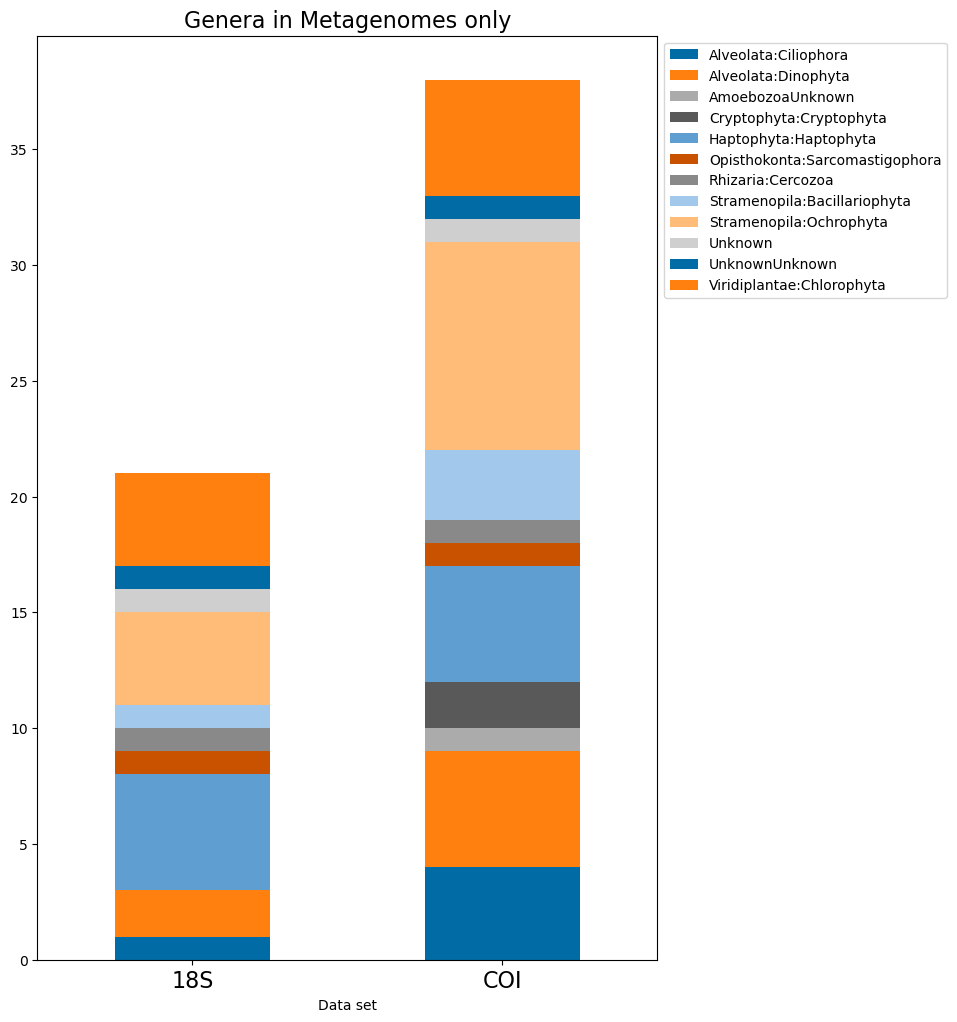

In [301]:
style.use('tableau-colorblind10')

ax = pivot.plot.bar(stacked=True, figsize=(8,12))

ax.legend(bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True)
ax.set_title('Genera in Metagenomes only', fontsize=16)
ax.set_xticklabels(['18S','COI'], rotation=0, fontsize=16)

In [302]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs/")
ax.figure.savefig('Mgns_only.png', bbox_inches='tight')

## 5. Taxa seen in both ASVs and mgns